course link: https://mp.weixin.qq.com/s/5LWWNA7f807gG6y2UfUrvA

# **Use LGMM, VAE and Transformer to Understand the Market Condition of SPY500**

# **Install Libraries**

In [9]:
# !pip install yfinance numpy pandas matplotlib seaborn

In [10]:
# !pip install -U scikit-learn

In [11]:
# !pip3 install torch torchvision

# LGMM（潜在高斯混合模型）Guassian distribution

LGMM把市场数据看作几个高斯分布的混合，每个分布代表一个状态。

缺点：
- 只能处理线性可分的情况
- 忽略时间序列的前后关系
- 对复杂的非线性模式无能为力


# VAE（变分自编码器）Variable AutoEncoder

VAE是一种深度学习模型，它能把高斯特征压缩到低维的「潜在空间」，在这个空间里，相似的市场状态会聚集在一起。

优点：

缺点：

# Transformer Encoder
理解时间序列，注意力机制。

优点：

缺点：

# Step 1 - 数据获取与特征工程

In [12]:
import matplotlib
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid", context='talk')
# matplotlib.rc("font", family='Microsoft YaHei')  # For Chinese characters
# plt.rcParams['font.sans-serif'] = ['SimHei']  # For Chinese characters
# import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Heiti TC'  # or another Chinese font available on your Mac
plt.rcParams['axes.unicode_minus'] = False  # Ensures minus sign displays properly


## 1.1 Download SPY Daily Data

In [13]:
# Download SPY Daily Data
symbol = 'SPY'
start = '2005-01-01'
end = datetime.today().strftime("%Y-%m-%d")

df = yf.download(symbol, start=start, end=end, progress=False)
df = df[("Close", "SPY")].to_frame(name="close") # 提取收盘价
df['logret'] = np.log(df['close']).diff() # 计算对数收益率
df.dropna(inplace=True) # 删除缺失值
df.reset_index(inplace=True) # 重置索引
df.rename(columns={'index':'Date'}, inplace=True) # 重命名日期列

print(df.head())

        Date      close    logret
0 2005-01-04  80.847031 -0.012295
1 2005-01-05  80.289116 -0.006925
2 2005-01-06  80.697304  0.005071
3 2005-01-07  80.581650 -0.001434
4 2005-01-10  80.962654  0.004717


## 1.2 构建三个关键特征

$$$$

In [14]:
# 特征工程
window_vol = 21 # 约一个月的交易日
window_mom = 5 # 短期动量窗口

df['ret_1d'] = df['logret'] # 日收益率
df['vol_21d'] = df['logret'].rolling(window_vol).std() * np.sqrt(252) # 年化波动率
df['mom_5d'] = df['close'].pct_change(window_mom) # 短期动量/5日动量

df.dropna(inplace=True) # 删除缺失值
features = df[['ret_1d', 'vol_21d', 'mom_5d']]
# ret_1d - 当日收益，反映即时涨跌
# vol_21d - 21日滚动波动率（年化），衡量市场的不确定性
# mom_5d - 5日动量，区分趋势和震荡

print(features.describe())

            ret_1d      vol_21d       mom_5d
count  5226.000000  5226.000000  5226.000000
mean      0.000405     0.157271     0.002336
std       0.012053     0.111122     0.024121
min      -0.115887     0.034158    -0.197934
25%      -0.003950     0.092703    -0.008046
50%       0.000715     0.129272     0.004102
75%       0.005794     0.184553     0.014864
max       0.135578     0.936684     0.194036


# Step 2 - 探索性数据分析（EDA）

## 2.1 数据可视化（return.收益率，volatility.波动率，momentum.动量）

$$
\text{Return: }r_t \;=\; \ln P_t \;-\; \ln P_{t-1}
$$

$$
\text{Volatility: }\mathrm{vol}_{t}^{21\text{d}}
\;=\;
\sqrt{252}\;\cdot\; \mathrm{std}\bigl(r_{t-20},\dots,r_{t}\bigr)
\;=\;
\sqrt{252}\;\cdot\;
\sqrt{\frac{1}{N-1}\sum_{i=0}^{N-1}\bigl(r_{t-i}-\bar r_t\bigr)^2},
\quad N=21,
$$

where $\displaystyle \bar r_t=\frac{1}{N}\sum_{i=0}^{N-1} r_{t-i}$.

$$
\text{Momentum: }\mathrm{mom}_{t}^{5\text{d}}
\;=\;
\frac{P_t - P_{t-5}}{P_{t-5}}
\;=\;
\frac{P_t}{P_{t-5}} - 1
$$

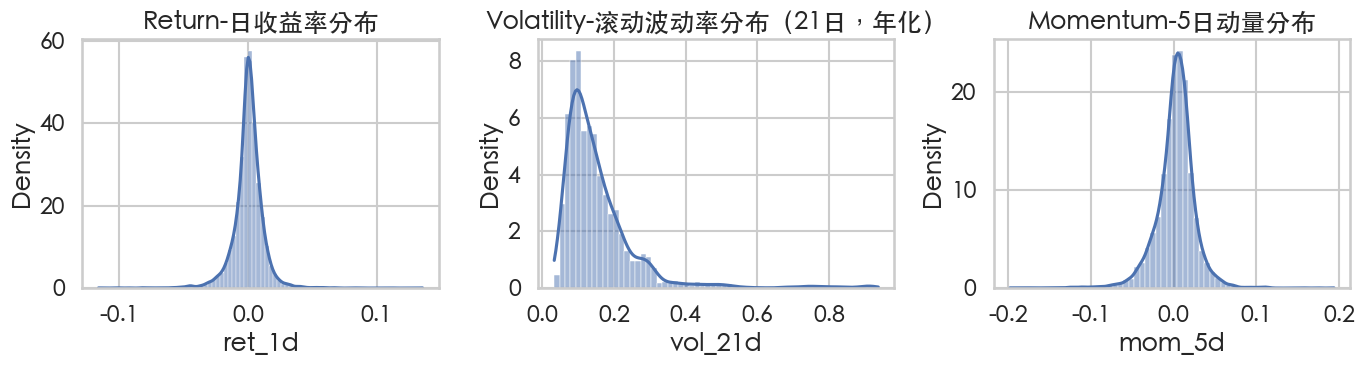

In [25]:
# 绘制特征分布
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.histplot(features['ret_1d'],
             kde=True,
             stat='density',
             bins=80)
plt.title('Return-日收益率分布')

plt.subplot(1, 3, 2)
sns.histplot(features['vol_21d'],
             kde=True,
             stat='density',
             bins=60)
plt.title('Volatility-滚动波动率分布（21日，年化）')

plt.subplot(1, 3, 3)
sns.histplot(features['mom_5d'],
             kde=True,
             stat='density',
             bins=60)
plt.title('Momentum-5日动量分布')

plt.tight_layout()
plt.show()

## 2.2 查看特征间的相关性

关键发现：
- 波动率和收益率呈弱负相关---波动率飙升时，收益率往往为负
- 动量和收益率有一定正相关

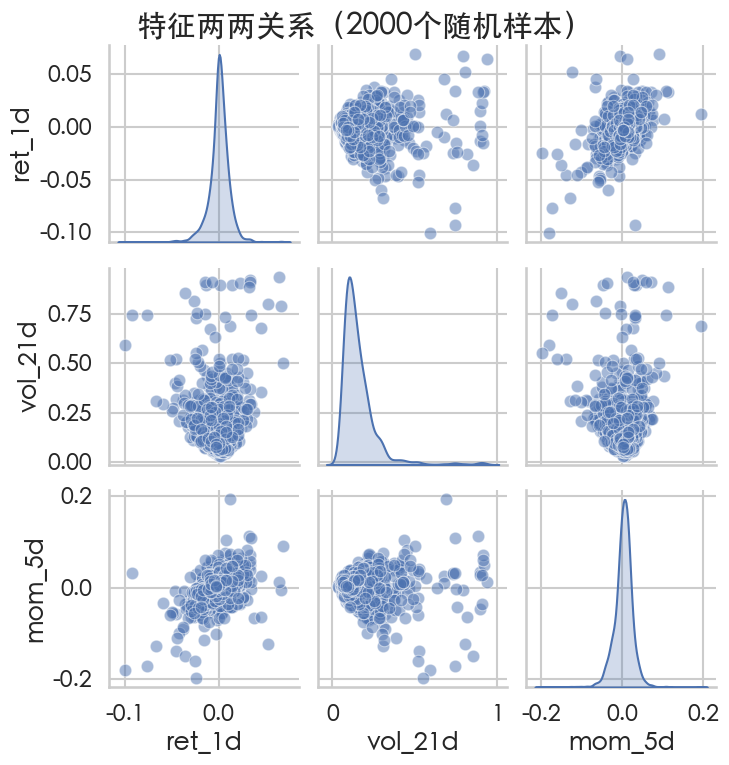

相关性矩阵：
            ret_1d   vol_21d    mom_5d
ret_1d   1.000000 -0.008051  0.423182
vol_21d -0.008051  1.000000 -0.056561
mom_5d   0.423182 -0.056561  1.000000


In [24]:
# 绘制特征配对图
sns.pairplot(features.sample(2000), 
             diag_kind='kde', 
             plot_kws={'alpha': 0.5})
plt.suptitle('特征两两关系（2000个随机样本）', y=1.02)
plt.show()

print("相关性矩阵：\n",features.corr())

# Step 3 - LGMM状态聚类

## 3.1 建模，标准化特征

In [32]:
# 特征标准化
scaler = StandardScaler()
# Standardize features by removing its mean and scaling to unit variance
X = scaler.fit_transform(features.values) 
dates = features.index

### Understanding the Standardized Data

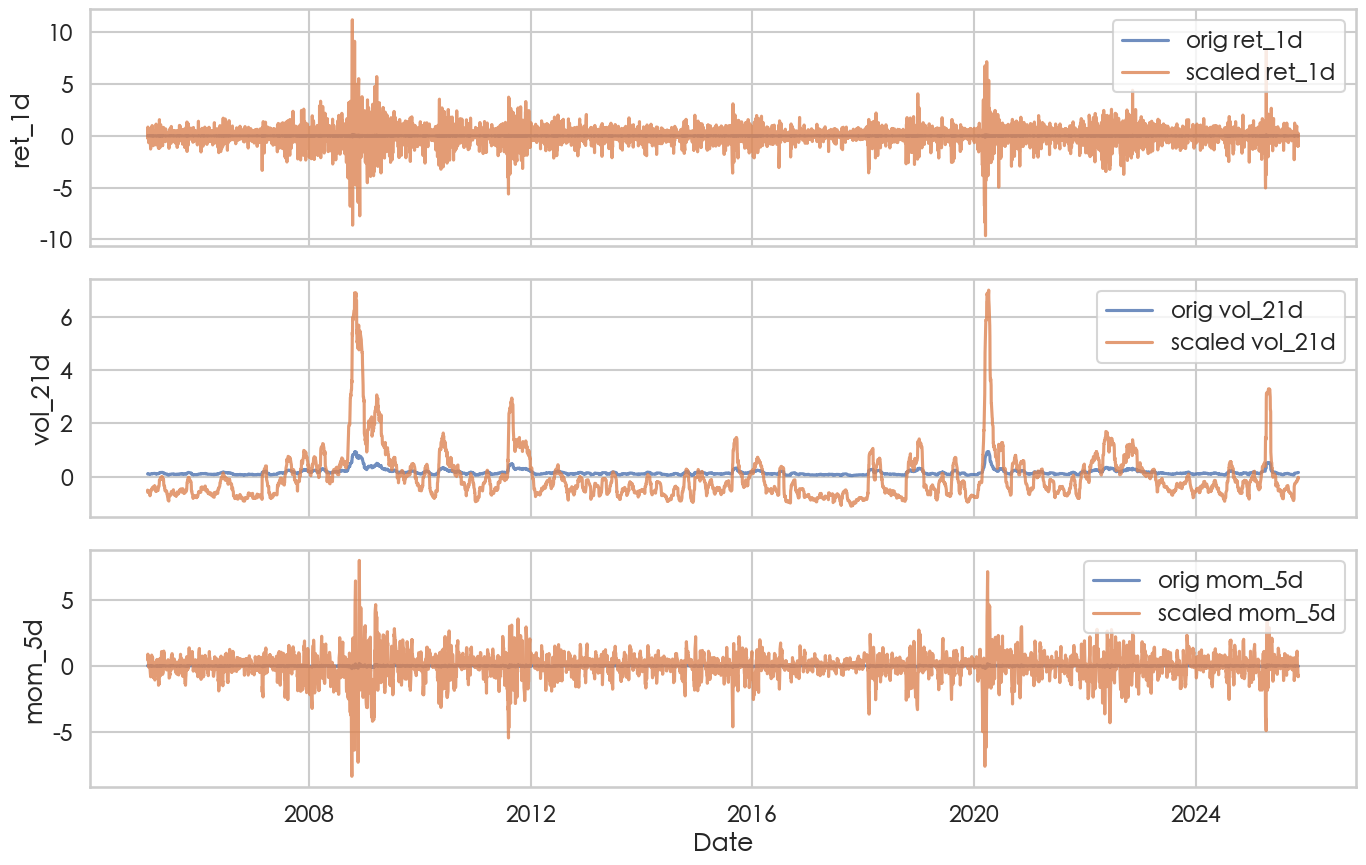

In [33]:
# plot original features and standardized X for each feature on separate subplots
x = df.loc[features.index, 'Date']  # datetime x-axis

orig = features.values
scaled = X

plt.figure(figsize=(14, 9))
for i, col in enumerate(features.columns):
    ax = plt.subplot(len(features.columns), 1, i + 1)
    ax.plot(x, orig[:, i], label=f'orig {col}', alpha=0.8)
    ax.plot(x, scaled[:, i], label=f'scaled {col}', alpha=0.8)
    ax.set_ylabel(col)
    ax.legend(loc='upper right')
    if i < len(features.columns) - 1:
        ax.tick_params(labelbottom=False)
plt.xlabel('Date')
plt.tight_layout()
plt.show()

## 3.2 拟合高斯混合模型
**为什么选择三个状态：**
- 通常是常有三种典型状态：平稳，正常，危机
- 可以通过BIC或AIC准则自动选择最佳状态数

In [39]:
# 拟合 LGMM
n_clusters = 3 # 设定 3 个状态
gmm = GaussianMixture(n_components=n_clusters,
                      covariance_type='full',
                      random_state=42)
gmm.fit(X)
lgmm_labels = gmm.predict(X) # 预测每个数据点的状态
print("LGMM 状态分布：", np.bincount(lgmm_labels))

LGMM 状态分布： [1977 2985  264]


In [40]:
lgmm_labels

array([1, 1, 1, ..., 0, 0, 0], shape=(5226,))

## 3.3 可视化聚类结果

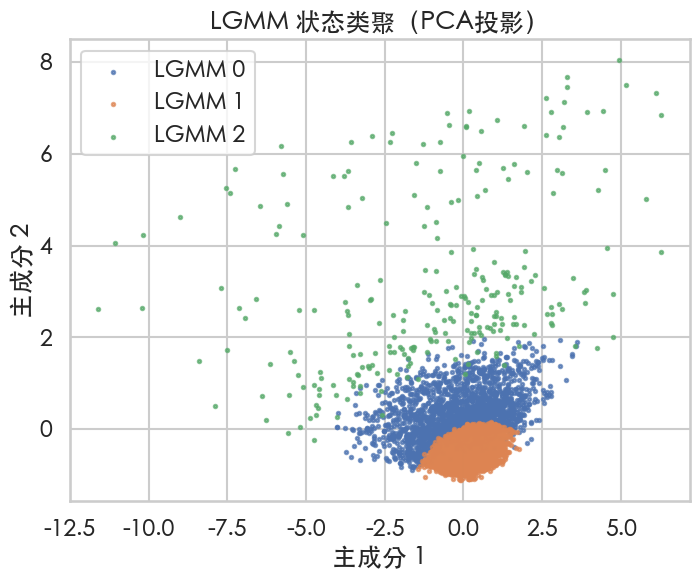

In [43]:
# 用PCA降维到2D以便可视化
pca = PCA(n_components=2)
Xp = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for k in range(n_clusters):
    plt.scatter(Xp[lgmm_labels == k, 0],
                Xp[lgmm_labels == k, 1],
                s = 6, alpha = 0.7, label=f'LGMM {k}')

plt.title('LGMM 状态类聚（PCA投影）')
plt.xlabel('主成分 1')
plt.ylabel('主成分 2')
plt.legend()
plt.show()

## 3.4 分析每个状态的统计特征
- 状态0: 低波动，小幅正收益，正动量 - 平稳期
- 状态1: 中等波动，接近零收益，中性动量 - 过渡期
- 状态0: 高波动，负收益，负动量 - 危机期

In [50]:
gmm.means_

array([[-0.03329489,  0.30929484, -0.12449874],
       [ 0.04844989, -0.50949823,  0.14790752],
       [-0.25452626,  2.96123241, -0.61769226]])

In [51]:
# 查看每个状态的特征均值和标准差
df_lgmm = features.copy()
df_lgmm['lgmm'] = lgmm_labels
print(df_lgmm.groupby('lgmm').agg(['mean', 'std']).T)

lgmm                 0         1         2
ret_1d  mean -0.000011  0.000990 -0.003098
        std   0.012885  0.005181  0.036290
vol_21d mean  0.196593  0.099810  0.512515
        std   0.053723  0.027546  0.198117
mom_5d  mean -0.001058  0.005990 -0.013567
        std   0.027219  0.011011  0.064227


In [52]:
df_lgmm.head()

,ret_1d,vol_21d,mom_5d,lgmm
20,0.003023,0.100448,0.017401,1
21,-0.002602,0.091182,0.013029,1
22,0.010619,0.094462,0.023844,1
23,-0.001332,0.093488,0.016164,1
24,0.001166,0.093215,0.010932,1


# Step 4 - VAE潜在模型

## 4.1 构建一个简单的VAE

In [ ]:
# 构建一个简单的VAE
# 设置设备和随机种子
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# 转换为 PyTorch 张量
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
dataset = TensorDataset(X_tensor)
loader = TensorDataset(X_tensor)

# VAE超参数
latent_dim = 2
input_dim = X.shape[1]
hidden_dim = 16
lr = 1e-3
epochs = 80

# 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # 编码器
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  # 均值
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # 对数方差
        # 解码器
        self.fc_decode = nn.Linear(latent_dim, hidden_dim) # 隐藏层
        self.fc_out = nn.Linear(hidden_dim, input_dim) # 输出层
        self.act = nn.ReLU()

    def encode(self, x):
        h = self.act(self.fc1(x)) # 隐藏层激活
        return self.fc_mu(h), self.fc_logvar(h) # 返回均值和对数方差
    
    def reparameterize(self, mu, logvar):
        # 重参数化技巧
        std = torch.exp(0.5 * logvar) # 计算标准差
        eps = torch.randn_like(std) # 采样标准正态分布
        return mu + eps * std

    def decode(self, z):
        h = self.act(self.fc_decode(z)) # 隐藏层激活
        return self.fc_out(h)

    def forward(self, x):
        mu, logvar = self.encode(x) # 编码
        z = self.reparameterize(mu, logvar) # 采样
        recon = self.decode(z) # 解码
        return recon, mu, logvar

# 初始化模型和优化器
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
# 初始化优化器
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [57]:
model

VAE(
  (fc1): Linear(in_features=3, out_features=16, bias=True)
  (fc_mu): Linear(in_features=16, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=2, bias=True)
  (fc_decode): Linear(in_features=2, out_features=16, bias=True)
  (fc_out): Linear(in_features=16, out_features=3, bias=True)
  (act): ReLU()
)

## 4.2 训练 VAE

- The VAE maximizes the evidence lower bound (ELBO). Practically we minimize the negative ELBO:
Loss = reconstruction term (measures how well decoder reconstructs x) + KL divergence (regularizes approximate posterior q(z|x) toward prior p(z)).

1. ELBO Inequality
$$
\log p_\theta(x) \;\ge\; \mathbb{E}_{q_\phi(z\mid x)}\big[\log p_\theta(x\mid z)\big] \;-\; 
D_{\mathrm{KL}}\big(q_\phi(z\mid x)\,\|\,p(z)\big)
$$

2. Negative ELBO (VAE loss objective)
$$
\mathcal{L}_{\mathrm{VAE}}(x;\theta,\phi)
\;=\;
-\,\mathbb{E}_{q_\phi(z\mid x)}\big[\log p_\theta(x\mid z)\big]
\;+\;
D_{\mathrm{KL}}\big(q_\phi(z\mid x)\,\|\,p(z)\big)
$$

3. Reparameterization trick
$$
z \;=\; \mu_\phi(x) \;+\; \sigma_\phi(x) \odot \epsilon,\qquad
\epsilon \sim \mathcal{N}(0, I)
$$

4. Reconstruction term (MSE, summed)
$$
\mathcal{L}_{\text{recon}}(x,\hat{x})
\;=\;
\sum_{n=1}^{D}\big(x_n - \hat{x}_n\big)^2
\quad\text{(equivalently: }\texttt{mse\_loss(recon, x, reduction='sum')}\text{)}
$$

5. KL divergence (diagonal Gaussian, closed form; also logvar form)
$$
\begin{aligned}
D_{\mathrm{KL}}\big(q(z\mid x)\,\|\,p(z)\big)
&=
\frac{1}{2}\sum_{j=1}^{L}\big(\mu_j^2 + \sigma_j^2 - 1 - \log\sigma_j^2\big) \\[6pt]
&= -\frac{1}{2}\sum_{j=1}^{L}\Big(1 + \operatorname{logvar}_j - \mu_j^2 - e^{\operatorname{logvar}_j}\Big)
\quad\text{(if }\operatorname{logvar}_j=\log\sigma_j^2\text{).}
\end{aligned}
$$

6. Full loss (recon sum + KL)
$$
\mathcal{L}(x)
\;=\;
\underbrace{\sum_{n=1}^{D}\big(x_n - \hat{x}_n\big)^2}_{\text{reconstruction}}
\;+\;
\underbrace{\Big(-\tfrac{1}{2}\sum_{j=1}^{L}\big(1 + \operatorname{logvar}_j - \mu_j^2 - e^{\operatorname{logvar}_j}\big)\Big)}_{\text{KL}}
$$

In [58]:
# VAE 损失函数：重构损失 + KL 散度
def loss_fn(recon, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon, x, reduction='sum') # 重构损失（均方误差）
    # KL 散度： 后验 q(z|x) 与先验 N(0,1) 之间的差异
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

# 训练循环
for ep in range(epochs):
    total_loss = 0.0
    for batch in loader:
        x_batch = batch[0]
        opt.zero_grad()
        recon, mu, logvar = model(x_batch)
        loss = loss_fn(recon, x_batch, mu, logvar)
        loss.backward()
        opt.step()
        total_loss += loss.item()

    if (ep + 1) % 10 == 0:
        print(f'Epoch [{ep+1}/{epochs}], Loss: {total_loss/len(X):.4f}')

Epoch [10/80], Loss: 2.0230
Epoch [20/80], Loss: 2.0019
Epoch [30/80], Loss: 1.9954
Epoch [40/80], Loss: 1.9744
Epoch [50/80], Loss: 1.9628
Epoch [60/80], Loss: 1.9635
Epoch [70/80], Loss: 1.9753
Epoch [80/80], Loss: 1.9601


## 4.3 获取潜在编码并聚类

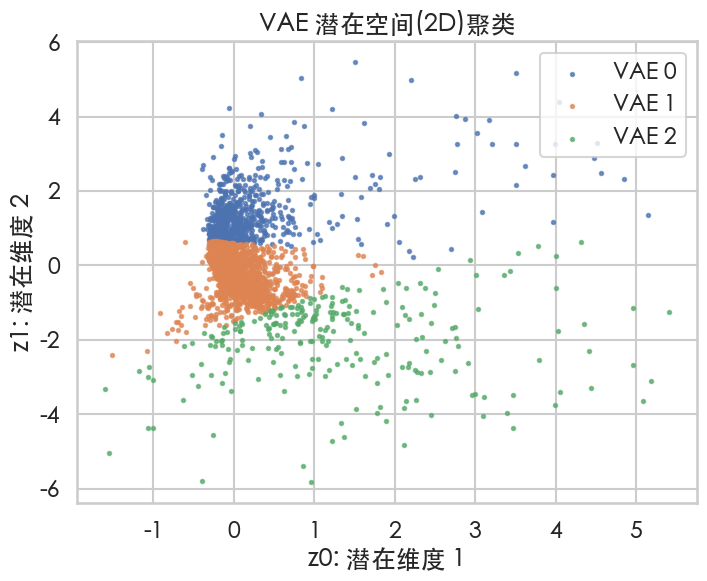

In [60]:
# 获取所有数据的潜在编码
model.eval()
with torch.no_grad():
    mu, logvar = model.encode(X_tensor)
    z = mu.cpu().numpy() # 使用均值作为确定性编码

# 在潜在空间用 KMeans 聚类
kmeans = KMeans(n_clusters=n_clusters,
                random_state=42).fit(z)
vae_labels = kmeans.labels_

# 可视化潜在空间
plt.figure(figsize=(8, 6))
for k in range(n_clusters):
    plt.scatter(z[vae_labels == k, 0],
                z[vae_labels == k, 1],
                s = 6, alpha = 0.7, label=f'VAE {k}')
plt.title('VAE 潜在空间(2D)聚类')
plt.xlabel('z0: 潜在维度 1')
plt.ylabel('z1: 潜在维度 2')
plt.legend()
plt.show()

## 4.4 VAE的优势
- 学习到的潜在空间更平滑，能捕捉非线性关系
- 相似行为的日期在潜在空间中聚集

# Step 5 - Transformer序列建模